In [1]:
print('Kernel Initialized')

Kernel Initialized


In [45]:
# Imports
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from utils import Utils
#import plot_utils as plotting
import toml
from sklearn import preprocessing, model_selection, metrics
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use("seaborn-v0_8-whitegrid")
import mplhep as hep
hep.style.use(hep.style.ATLAS)
from scipy.special import logit, expit
import os

mpl.rcParams.update({
    'text.usetex': False,
    'font.family': 'stixgeneral',
    'mathtext.fontset': 'stix',
    })

#import verstack

random.seed(42)


In [6]:
def load_multiple_feather_files(file_list:list, selection:str, N_events:int, columns_to_read:list):
    print('Starts loading files..')
    files = []
    List_uniques_list = []
    for file_path in file_list:
        files.append(pd.read_feather(path=file_path, columns=columns_to_read, use_threads=True, storage_options=None))
    print('Done loading..')

    for i in range(len(files)):
        files[i] = files[i].query(selection)
        List_uniques = list(files[i]['info_event_number'].unique()[:N_events])
        List_uniques_list.append(List_uniques)
        files[i] = files[i][(files[i]['info_event_number'].isin(List_uniques))]

    print(f"Number of uniques: {[len(i) for i in List_uniques_list]}, total = {sum([len(i) for i in List_uniques_list])}")
    print(f"Length of files: {[len(i) for i in files]}, total = {sum([len(i) for i in files])}")

    df_files = pd.concat(files)
    print('Done..')
    print()

    return df_files

config = toml.load('config.toml')

Features_to_be_read = []
for k, v in config['features'].items():
    Features_to_be_read.extend(v)
#Features_to_be_read = ['BeeKst_diElectron_mass','B_mass_Kstar_mass_closer','BeeKst_B_mass','BeeKst_diElectron_gsf_id_isOK','info_event_number']

files_dictionary = {
    'MC_signal': sorted([config['PATHS']['feather'] + x for x in os.listdir(config['PATHS']['feather']) if 'MC_signal_all_ntuple' in x ]),
    'Data': sorted([config['PATHS']['feather'] + x for x in os.listdir(config['PATHS']['feather']) if 'Data_All_K_ntuple-data18_13TeV_periodK_part' in x ])
    }

Data_full = load_multiple_feather_files(
    file_list = files_dictionary['Data'], 
    selection = Utils.selection_cuts()['main'],
    N_events = -1, 
    columns_to_read = None)

Starts loading files..
Done loading..
Number of uniques: [107128, 100613, 89653, 87702, 81122, 81064, 75831, 57811, 46439, 53949, 67173], total = 848485
Length of files: [2612166, 2434696, 2193172, 2147878, 1964466, 1985248, 1858130, 1463502, 1157470, 1428218, 1751054], total = 20996000
Done..



In [15]:
Data_full_ = Data_full.loc[:,['entry', 'subentry', 'info_event_number','event_number']]
Data_full_['count_multiplicity'] = 1


In [20]:
Data_full_

entry  subentry  info_event_number  event_number  count_multiplicity
0             0         6         1022641642    1022641642                   1
1             0         7         1022641642    1022641642                   1
2             1         0         1022085070    1022085070                   1
3             1         1         1022085070    1022085070                   1
4             1         6         1022085070    1022085070                   1
...         ...       ...                ...           ...                 ...
2039177  129649        17          352444532     352444532                   1
2039178  129649        18          352444532     352444532                   1
2039179  129649        19          352444532     352444532                   1
2039180  129649        20          352444532     352444532                   1
2039181  129649        21          352444532     352444532                   1

[20996000 rows x 5 columns]

In [36]:
Data_full_[Data_full_['event_number']==1022641642]

entry  subentry  info_event_number  event_number  count_multiplicity
0      0         6         1022641642    1022641642                   1
1      0         7         1022641642    1022641642                   1

In [40]:

Data_full_.groupby(by=["event_number"]).sum().loc[1022641642]

entry                          0
subentry                      13
info_event_number     2045283284
count_multiplicity             2
Name: 1022641642, dtype: int64

In [11]:
Data_full['count_multiplicity'] = 1
Data_full['subentry']

Data_full.groupby(by=["entry"]).sum()

subentry  mc_channel_number  event_number  BeeKst_a0xy_maxSumPt2  \
entry                                                                      
0           3115                -86   60510662815               2.933528   
1           3681               -136   72271341430               0.894951   
2           2031               -104  101655700639               1.169040   
3           2015               -104   41515933380               2.776400   
4           5122               -148   93369507073               3.193908   
...          ...                ...           ...                    ...   
211370         4                 -3    7918888071               0.077726   
211371      1114                -35   92371033405               0.322173   
211374       434                -28   73906354396               0.359183   
211375      1352                -48  126676392864               0.311340   
211376        19                 -6   15838501992               0.070656   

        BeeKst_a0xy_maxSumPt2_err  BeeKst_a0xy_minA0  BeeKst_a0xy_minA0_err  \
entry                                                                         
0                        2.321202           2.933528               2.321202   
1                        2.258735           0.893403               2.252205   
2                        1.803679           1.169040               1.803679   
3                        2.310666           2.744669               2.312072   
4                        2.204681           3.193908               2.204681   
...                           ...                ...                    ...   
211370                   0.050574           0.077726               0.050574   
211371                   0.566877           0.322173               0.566877   
211374                   0.356857           0.359183               0.356857   
211375                   0.777370           0.311340               0.777370   
211376                   0.058804           0.070656               0.058804   

        BeeKst_a0xy_minZ0  BeeKst_a0xy_minZ0_err  BeeKst_Lxy_maxSumPt2  ...  \
entry                                                                   ...   
0                2.933528               2.321202            -15.016685  ...   
1                0.893403               2.252205             29.405897  ...   
2                1.169040               1.803679              2.022900  ...   
3                2.744669               2.312072              4.174207  ...   
4                3.193908               2.204681             44.942196  ...   
...                   ...                    ...                   ...  ...   
211370           0.077726               0.050574              2.176490  ...   
211371           0.322173               0.566877             -7.881656  ...   
211374           0.359183               0.356857              1.998145  ...   
211375           0.311340               0.777370              0.097628  ...   
211376           0.070656               0.058804              0.958036  ...   

        tracks_dEdx_pT_diff  tracks_dEdx_pT_ratio  info_sample_weight  \
entry                                                                   
0                 -8.025023             83.166344                  86   
1                -19.483292            122.223206                 136   
2                 -0.004904             99.794327                 104   
3                  1.765144             88.766418                 104   
4                  5.603878            159.244080                 148   
...                     ...                   ...                 ...   
211370             0.438355              3.602270                   3   
211371             0.670626             37.215717                  35   
211374            -0.511206             28.109200                  28   
211375            -3.572505             52.165909                  48   
211376             1.122220              7.770933                   6   

        info_

In [41]:
#Data_full['count_multiplicity'] = 1
multiplicity = Data_full_.groupby(by=["event_number"]).sum()['count_multiplicity'].sort_values(ascending=False).values
multiplicity

array([1650, 1102,  851, ...,    1,    1,    1])

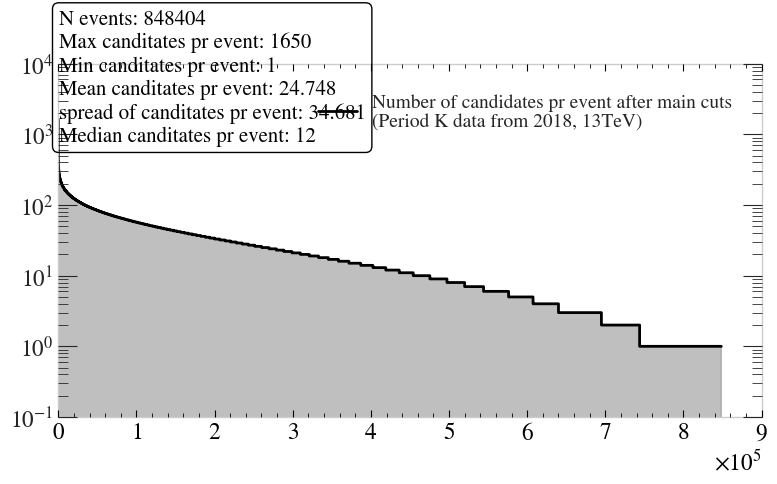

In [46]:
fig, ax = plt.subplots(figsize=(8, 5)) 
ax.plot(range(1,len(multiplicity)+1),multiplicity,drawstyle="steps",label='Number of candidates pr event after main cuts\n(Period K data from 2018, 13TeV)',color='black')
ax.fill_between(range(1,len(multiplicity)+1), multiplicity, step="pre", alpha=0.5, color='grey')
ax.text(600,800,f"N events: {len(multiplicity):.0f}" +"\n"+f"Max canditates pr event: {np.max(multiplicity):.0f}"  +"\n"+f"Min canditates pr event: {np.min(multiplicity):.0f}"+"\n"+ f"Mean canditates pr event: {np.mean(multiplicity):.3f}"  +"\n"+f"spread of canditates pr event: {np.std(multiplicity):.3f}" +"\n"+f"Median canditates pr event: {np.median(multiplicity):.0f}", fontsize=15,c='black', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))

#ax.set(xlim=(0,1500),ylim=(0,None),ylabel='Candidate Multiplicity', xlabel='Sorted Events for Higher Multiplicity')
ax.legend()
ax.set_yscale('log')
plt.tight_layout()

plt.savefig("Multiplicity.png")
plt.show()


In [47]:
np.diff([1,2])

array([1])